# Práctico 1: Recomendación de Artistas

En este práctico trabajaremos con el conjuto de datos de [LastFM](https://grouplens.org/datasets/hetrec-2011/) para el desarrollo de un sistema de recomendación que, dado el nombre de un artista musical, devuelve una lista de artistas "similares".

Para el práctico utilizaremos el conjunto de datos de LastFM que consiguieron del [notebook de instalación](./instalacion.ipynb). Se recomienda leer el [Readme](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-lastfm-readme.txt) de los datos para saber más sobre que información contiene cada archivo.

La idea del práctico es hacer un análisis muy sencillo del conjunto de datos y desarrollar un sistema de recomendación basado en filtrado colaborativo (usando Surpr!se), a partir de los datos existentes.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
# basic algorithms
from surprise import NormalPredictor, BaselineOnly
from surprise import SVD, SVDpp, NMF
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, SlopeOne, CoClustering


In [2]:
artist_data = pd.read_csv("./data/artists.dat", sep="\t")
artist_data.head()

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [3]:
user_artist_plays = pd.read_csv("./data/user_artists.dat", sep="\t")
user_artist_plays.head(5)

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [4]:
tags = pd.read_csv("./data/tags.dat", sep = '\t', encoding = 'latin-1')
tags.head(5)

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal


In [5]:
user_taggedartists = pd.read_csv('./data/user_taggedartists.dat', sep = '\t')
user_taggedartists.head(5)

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009


## Ejercicio 1 - Análisis Exploratorio de Datos

En esta primera parte deberán hacer un análisis exploratorio de los datos, aprovechando toda la información brindada por el conjunto. A partir de eso podrán tener mayor idea de qué tipo de datos estarán enfrentando (describe o hist).

Algunas preguntas para responder:
- ¿Cuáles son los artistas que fueron más escuchados?
- ¿Cómo es la distribución de cantidad de listens por user?
- ¿Es posible ver el género más escuchado?

#### Valido los tipos de datos para tratarlos correctamente mas adelante

In [6]:
user_artist_plays.dtypes

userID      int64
artistID    int64
weight      int64
dtype: object

In [7]:
artist_data.dtypes

id             int64
name          object
url           object
pictureURL    object
dtype: object

#### Realizo la union de tablas, para encontrar de forma mas facil los artistas mas escuchados

In [8]:
unir=pd.merge(user_artist_plays, artist_data, left_on='artistID', right_on='id', how='inner')
unir.head(10)

,userID,artistID,weight,id,name,url,pictureURL
0,2,51,13883,51,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg
1,4,51,228,51,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg
2,27,51,85,51,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg
3,28,51,10,51,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg
4,62,51,528,51,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg
5,63,51,563,51,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg
6,66,51,910,51,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg
7,73,51,1962,51,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg
8,96,51,63,51,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg
9,117,51,1244,51,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg


#### Realizo la union de tablas, para encontrar el genero mas escuchado

In [9]:
unir_tag=pd.merge(tags, user_taggedartists, left_on='tagID', right_on='tagID', how='inner')
unir_tag.head(10)

,tagID,tagValue,userID,artistID,day,month,year
0,1,metal,4,918,1,5,2008
1,1,metal,12,181,1,5,2010
2,1,metal,12,198,1,2,2010
3,1,metal,12,500,1,2,2010
4,1,metal,12,503,1,3,2010
5,1,metal,12,512,1,2,2010
6,1,metal,12,514,1,2,2010
7,1,metal,12,517,1,7,2010
8,1,metal,12,519,1,2,2010
9,1,metal,12,707,1,5,2010


#### Agrupo por nombre, y sumo sus canciones

In [10]:
unir_todas=pd.merge(unir, unir_tag, left_on='artistID', right_on='artistID')
unir_todas.head(10)

,userID_x,artistID,weight,id,name,url,pictureURL,tagID,tagValue,userID_y,day,month,year
0,2,51,13883,51,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg,13,chillout,1380,1,12,2009
1,2,51,13883,51,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg,14,ambient,1202,1,3,2007
2,2,51,13883,51,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg,16,new wave,4,1,12,2007
3,2,51,13883,51,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg,16,new wave,43,1,10,2010
4,2,51,13883,51,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg,16,new wave,62,1,11,2009
5,2,51,13883,51,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg,16,new wave,63,1,2,2011
6,2,51,13883,51,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg,16,new wave,117,1,6,2008
7,2,51,13883,51,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg,16,new wave,156,1,1,2009
8,2,51,13883,51,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg,16,new wave,196,1,3,2008
9,2,51,13883,51,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg,16,new wave,264,1,11,2007


In [11]:

unir_todas2=pd.merge(user_artist_plays, unir_tag, left_on='artistID', right_on='artistID')
unir_todas2.head(10)

,userID_x,artistID,weight,tagID,tagValue,userID_y,day,month,year
0,2,51,13883,13,chillout,1380,1,12,2009
1,2,51,13883,14,ambient,1202,1,3,2007
2,2,51,13883,16,new wave,4,1,12,2007
3,2,51,13883,16,new wave,43,1,10,2010
4,2,51,13883,16,new wave,62,1,11,2009
5,2,51,13883,16,new wave,63,1,2,2011
6,2,51,13883,16,new wave,117,1,6,2008
7,2,51,13883,16,new wave,156,1,1,2009
8,2,51,13883,16,new wave,196,1,3,2008
9,2,51,13883,16,new wave,264,1,11,2007


In [12]:
total = unir.groupby(["name"])[["artistID","name", "weight"]].sum()
total.head(5)

,artistID,weight
name,,
!!!,29692,2826
!DISTAIN,21270,1257
!deladap,8209,65
#####,6072,3707
#2 Orchestra,10004,144


#### Ordeno de mayor a menor y muestro los 10 artistas mas escuchados

In [13]:
most_populous_counties = total.sort_values('weight', ascending=False).head(10)
most_populous_counties

,artistID,weight
name,,
Britney Spears,150858,2393140
Depeche Mode,20304,1301308
Lady Gaga,54379,1291387
Christina Aguilera,118844,1058405
Paramore,198702,963449
Madonna,28743,921198
Rihanna,139392,905423
Shakira,223619,688529
The Beatles,108960,662116


In [14]:
most_populous_counties2 = total.sort_values('weight', ascending=False)
most_populous_counties2.describe()

,artistID,weight
count,17632.000000,1.763200e+04
mean,17538.650522,3.923774e+03
std,17414.174214,3.409934e+04
min,3.000000,1.000000e+00
25%,8631.750000,1.130000e+02
50%,13998.000000,3.500000e+02
75%,18377.250000,1.234250e+03
max,281244.000000,2.393140e+06


In [15]:
total1 = unir_todas2.groupby(["tagValue"])[["artistID","tagValue", "weight"]].sum()
total1.head(10)

,artistID,weight
tagValue,,
'80s,155441,268881
-pearl fashion music,51843,1167
0 play yet,1177798,347355
00,53734,51602
00's,886262,4374005
007,25805,4635
00s,37369328,100189321
00s rock,52670,17862
1,92057,3374


In [16]:
total2 = unir_todas.groupby(["tagValue"])[["artistID","tagValue", "weight"]].sum()
total2.head(10)


,artistID,weight
tagValue,,
'80s,155441,268881
-pearl fashion music,51843,1167
0 play yet,1177798,347355
00,53734,51602
00's,886262,4374005
007,25805,4635
00s,37369328,100189321
00s rock,52670,17862
1,92057,3374


In [17]:
most_populous_counties1 = total1.sort_values('weight', ascending=False).head(10)
most_populous_counties1


,artistID,weight
tagValue,,
pop,281513558,1043039517
rock,411806723,622063102
female vocalists,220695362,611535548
dance,128377286,569648216
alternative,272086388,403229595
electronic,186695931,400420167
alternative rock,138522353,231167101
indie,223912562,215784773
80s,109446145,209870819


In [18]:
most_populous_counties2 = total2.sort_values('weight', ascending=False).head(10)
most_populous_counties2


,artistID,weight
tagValue,,
pop,281513558,1043039517
rock,411806723,622063102
female vocalists,220695362,611535548
dance,128377286,569648216
alternative,272086388,403229595
electronic,186695931,400420167
alternative rock,138522353,231167101
indie,223912562,215784773
80s,109446145,209870819


Text(0.5, 1.0, 'Distribucion de Reproducciones')

<Figure size 1080x504 with 0 Axes>

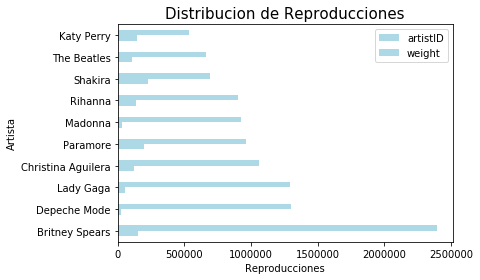

In [19]:
plt.figure(figsize=(15,7))
most_populous_counties.plot(kind="barh",color='lightblue')
plt.xlabel('Reproducciones') 
plt.ylabel('Artista') 
plt.title('Distribucion de Reproducciones',fontsize = 15)

Text(0.5, 1.0, 'Distribucion de Reproducciones')

<Figure size 1080x504 with 0 Axes>

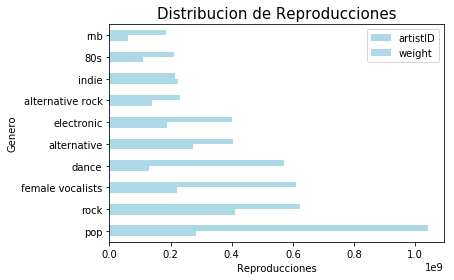

In [20]:

plt.figure(figsize=(15,7))
most_populous_counties2.plot(kind="barh",color='lightblue')
plt.xlabel('Reproducciones') 
plt.ylabel('Genero') 
plt.title('Distribucion de Reproducciones',fontsize = 15)

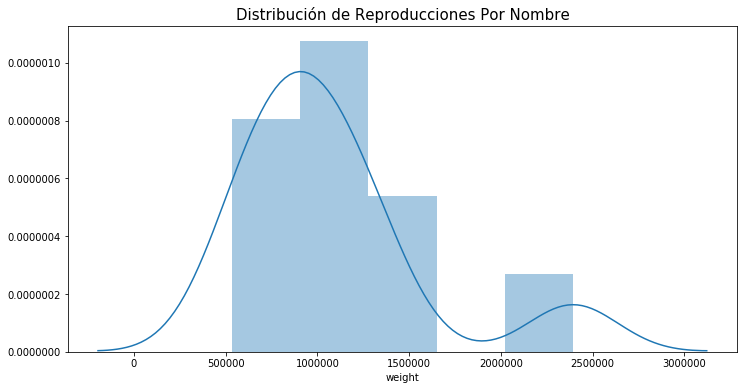

In [21]:


#Para conocer como se distribuyen los datos de listens realizamos un histograma
plt.figure(figsize=(12,6))
plt.title('Distribución de Reproducciones Por Nombre', fontsize = 15)
sns.distplot(most_populous_counties['weight']);

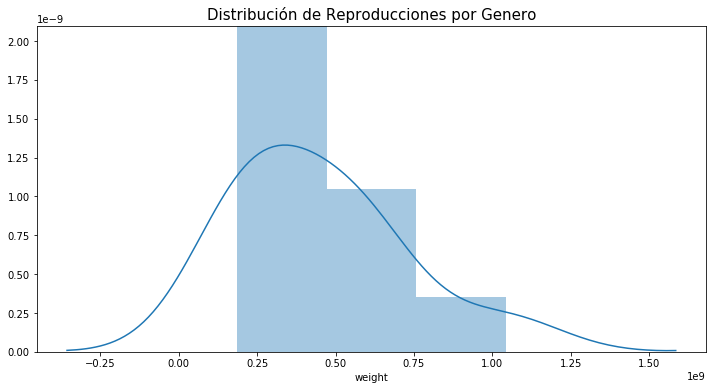

In [22]:
#Para conocer como se distribuyen los datos de listens realizamos un histograma
plt.figure(figsize=(12,6))
plt.title('Distribución de Reproducciones por Genero', fontsize = 15)
sns.distplot(most_populous_counties2['weight']);

## Ejercicio 2 - Matriz de Usuario-Contenido

En este ejercicio, a partir del conjunto de datos, deberán generar una matriz de usuario-contenido. Tengan en cuenta que los ratings, en este caso, son implícitos, puesto que se dan a partir de la cantidad de veces que un usuario escuchó a cierto artista.

#### Creamos la matriz con los usuarios y artistas

In [23]:
matriz_uap = user_artist_plays.pivot(index='userID', columns='artistID', values='weight').fillna(0)
matriz_uap.head()


artistID,1,2,3,4,5,6,7,8,9,10,...,18736,18737,18738,18739,18740,18741,18742,18743,18744,18745
userID,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
matriz_uap.sum()

artistID
1          771.0
2         8012.0
3          775.0
4          563.0
5          913.0
6         5080.0
7        96201.0
8        10791.0
9         9621.0
10        4067.0
11        1992.0
12        9564.0
13        2376.0
15        8963.0
16        1381.0
17        1780.0
18        3820.0
19        8685.0
20          60.0
21         110.0
22          58.0
23        1699.0
24         290.0
25       15166.0
26         558.0
27        5076.0
28        2109.0
30       38949.0
31        2134.0
32        9256.0
          ...   
18713      171.0
18714      163.0
18715      139.0
18716      133.0
18717      132.0
18718      132.0
18719      118.0
18720      112.0
18721      108.0
18722      107.0
18723       87.0
18724       84.0
18725      758.0
18726      337.0
18727      297.0
18728      281.0
18729      280.0
18730      263.0
18734     1032.0
18735      895.0
18736      879.0
18737      560.0
18738      408.0
18739      379.0
18740      320.0
18741      301.0
18742      294.0
18743

## Ejercicio 3 - Entrenamiento del algoritmo de recomendación

Utilizando las herramientas brindadas por Surpr!se, entrenen varios modelos de sistemas de recomendación basados en filtrado colaborativo a partir de su matriz de usuario-contenido. Recuerden tener en cuenta lo aprendido en la diplomatura a la hora de evaluar y validar el modelo.

Si necesitan inspiración, les recomiendo revisar [este notebook con información de como entrenar un sistema de recomendación con Surpr!se](https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Building%20Recommender%20System%20with%20Surprise.ipynb).

In [ ]:
# definimos rango de valores
minimo=user_artist_plays.weight.min()
maximo=user_artist_plays.weight.max()
print( "El minimo es:",minimo )
print( "El maximo es:",maximo )


El minimo es: 1
El maximo es: 352698


In [ ]:
reader = Reader(line_format='user item rating', sep=' ', skip_lines=3, rating_scale = ( minimo, maximo ) )
data = Dataset.load_from_df( user_artist_plays, reader )
print("> Creating trainset...")
trainset = data.build_full_trainset()
print("> OK")


> Creating trainset...
> OK


In [ ]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')  

#### Train and Predict

In [ ]:
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

## Ejercicio 4 - Sistema de recomendación

A partir del mejor modelo de recomendación que hayan sugerido en el caso anterior, y utilizando los datos del archivo `artist.dat`, armar un sistema de recomendación sencillo que, dado un nombre de un artista, devuelva el top 10 de artistas más similares.

La idea es que el sistema tome el nombre de un artista y devuelva el nombre de otros artistas (no simplemente tomar y devolver IDs). Se recomienda [revisar este notebook para inspiración (ver el paso número 5)](https://github.com/topspinj/pydata-workshop/blob/master/tutorial.ipynb).

In [ ]:
from scipy.sparse import csr_matrix

def create_X(df):

    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        artist_mapper: dict that maps artist id's to movie indices
        artist_inv_mapper: dict that maps artists indices to movie id's
    """

    M = df['userID'].nunique()
    N = df['artistID'].nunique()

    user_mapper = dict(zip(np.unique(df["userID"]), list(range(M))))
    artist_mapper = dict(zip(np.unique(df["artistID"]), list(range(N))))
    
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userID"])))
    artist_inv_mapper = dict(zip(list(range(N)), np.unique(df["artistID"])))
    
    user_index = [user_mapper[i] for i in df['userID']]
    item_index = [artist_mapper[i] for i in df['artistID']]

    X = csr_matrix((df["weight"], (user_index,item_index)), shape=(M,N))
    
    return X, user_mapper, artist_mapper, user_inv_mapper, artist_inv_mapper

X, user_mapper, artist_mapper, user_inv_mapper, artist_inv_mapper = create_X(user_artist_plays)

### Evaluando Sparsity

In [ ]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

In [ ]:
n_ratings_per_user = X.getnnz(axis=0)

print(f"Most rated artist has {n_ratings_per_user.max()} ratings.")
print(f"Least rated artist has {n_ratings_per_user.min()} ratings.")

In [ ]:
n_ratings_per_artist = X.getnnz(axis=0)

print(f"Most rated movie has {n_ratings_per_artist.max()} ratings.")
print(f"Least rated movie has {n_ratings_per_artist.min()} ratings.")

In [ ]:

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_artist, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per Artist", fontsize=14)
plt.xlabel("number of ratings per Artist")
plt.ylabel("density")
plt.show()

### Normalizo los datos

In [ ]:
sum_ratings_per_artist = X.sum(axis=0)
mean_rating_per_artist = sum_ratings_per_artist/n_ratings_per_artist

In [ ]:
X_mean_artist = np.tile(mean_rating_per_artist, (X.shape[0],1))

In [ ]:
X_mean_artist.shape

In [ ]:
X_norm = X - csr_matrix(X_mean_artist)

In [ ]:
print("Original X:", X[0].todense())
print("Normalized X:", X_norm[0].todense())

### Recomendaciones con k-Nearest Neighbors

In [ ]:

from sklearn.neighbors import NearestNeighbors

def find_similar_artist(artist_id, X, artist_mapper, artist_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar movie ID's
    """
    X = X.T
    neighbour_ids = []
    
    artist_ind = artist_mapper[artist_id]
    artist_vec = X[artist_ind]
    if isinstance(artist_vec, (np.ndarray)):
        artist_vec = artist_vec.reshape(1,-1)
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(artist_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(artist_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [ ]:
##similar_artist = find_similar_artist(1, X_norm, artist_mapper, artist_inv_mapper, k=10)
##similar_artist

In [ ]:
artist_data = artist_data.rename( columns = { 'id': 'artistID' } )


def recommend_artist(name, k):

    print('Los', k, 'artistas recomendados para', name, 'son:')
    
    artist_name = artist_data['name'] == name
    artist_id = artist_data[ artist_name ]['artistID'].max()
    
    recommend = find_similar_artist(artist_id, X, artist_mapper, artist_inv_mapper, k, metric='cosine')
    
    for idx in recommend:
        
        artist_id = artist_data[ 'artistID' ] == idx
        name = artist_data[artist_id ]['name'].max()
        print( name )

In [ ]:
recommend_artist('Shakira',10)


In [ ]:
recommend_artist('Pink',10)